In [ ]:
!pip install jupyter pdvega
!pip install openai
!pip install tiktoken

import os
import json
import openai
import pdvega
import tiktoken
import psycopg2
import getpass
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Access data using Google BigQuery.
from google.colab import auth
from google.cloud import bigquery

%matplotlib inline

In [ ]:
# Authenticate user to get access to mimiciv databse
auth.authenticate_user()

# Set up environment variables
project_id = 'striking-pipe-360404'
if project_id == 'CHANGE-ME':
  raise ValueError('You must change project_id to your GCP project.')
os.environ["GOOGLE_CLOUD_PROJECT"] = project_id

from google.colab import drive
drive.mount('/content/gdrive/')

path_prefix = '/content/gdrive/My Drive/EICU/'

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
# Read data from BigQuery into pandas dataframes.
def run_query(query, project_id=project_id):
  return pd.io.gbq.read_gbq(
      query,
      project_id=project_id,
      dialect='standard')


def num_tokens_from_string(string: str, encoding_name="cl100k_base") -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

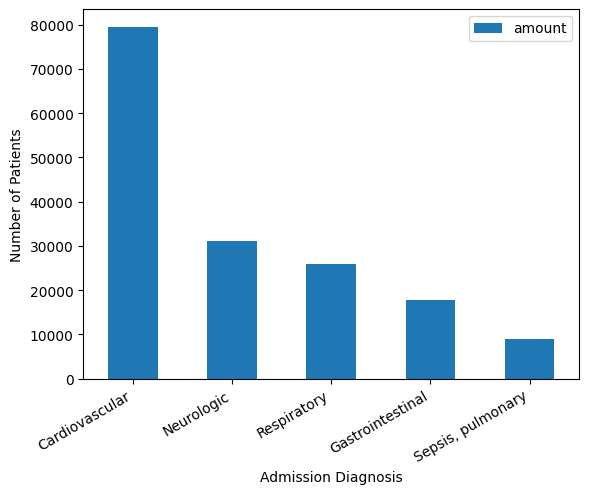

In [ ]:
query = """
SELECT admitdxname,
       COUNT(*) as total_num
FROM `physionet-data.eicu_crd.admissiondx`
WHERE admitdxname != 'No'
AND admitdxname != 'Yes'
GROUP BY admitdxname
ORDER BY total_num DESC
LIMIT 5
"""

df_total_admidx = run_query(query)
# df_total_admidx.head()

ax = df_total_admidx.plot.bar(x='admitdxname', y='total_num', rot=0)
plt.xlabel('Admission Diagnosis')
plt.ylabel('Number of Patients')
plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
ax.legend(['amount'])
plt.show()

In [ ]:
admitdxname = 'Cardiovascular'

query = """
SELECT patientunitstayid
FROM `physionet-data.eicu_crd.admissiondx`
WHERE admitdxname = 'Cardiovascular'
LIMIT 100
"""

df_patients_with_cardio = run_query(query)
df_patients_with_cardio

,patientunitstayid
0,2900217
1,2900392
2,2900527
3,2901035
4,2901080
...,...
95,2938020
96,2939543
97,2939581
98,2939753


In [ ]:
query = """
SELECT patient.uniquepid,
       patient.patientunitstayid
FROM `physionet-data.eicu_crd.patient` as patient
WHERE patient.patientunitstayid IN
(
  SELECT admitdx.patientunitstayid
  FROM `physionet-data.eicu_crd.admissiondx` as admitdx
  WHERE admitdx.admitdxname = 'Cardiovascular'
)
ORDER BY patient.uniquepid
"""

query = """
SELECT patient.uniquepid,
       patient.patientunitstayid
FROM `physionet-data.eicu_crd.patient` as patient
JOIN `physionet-data.eicu_crd.admissiondx` as admitdx
ON patient.patientunitstayid = admitdx.patientunitstayid
WHERE admitdx.admitdxname = 'Cardiovascular'
ORDER BY patient.uniquepid
"""

df_pid_stayid = run_query(query)
df_pid_stayid

,uniquepid,patientunitstayid
0,002-10018,204602
1,002-10050,211144
2,002-10050,221005
3,002-10052,151900
4,002-1007,204935
...,...,...
79555,035-9942,3351729
79556,035-9945,3340416
79557,035-9959,3340321
79558,035-996,3345874


In [ ]:
query = """
SELECT patient.uniquepid,
       (patient.unitdischargeoffset - patient.hospitaladmitoffset) as stay,
       patient.patientunitstayid,
       patient.patienthealthsystemstayid,
       admitdx.admitdxname,
       patient.apacheadmissiondx,
       patient.hospitaladmittime24,
       patient.hospitaladmitoffset,
       patient.hospitaladmitsource,
       patient.hospitaldischargeyear,
       patient.hospitaldischargetime24,
       patient.hospitaldischargeoffset,
       patient.unitadmittime24,
       patient.unitadmitsource,
       patient.unitdischargetime24,
       patient.unitdischargeoffset,
       patient.hospitaldischargestatus,
       patient.unitdischargestatus
FROM `physionet-data.eicu_crd.admissiondx` as admitdx
JOIN `physionet-data.eicu_crd.patient` as patient
ON admitdx.patientunitstayid = patient.patientunitstayid
WHERE admitdxname = 'Cardiovascular'
AND patient.uniquepid = '018-78755'
ORDER BY patientunitstayid
"""
df_single_patient = run_query(query)
df_single_patient

# patienthealthsystemstayid is the same in the same year
# total_stay = unitdischargeoffset - hospitaladmitoffset

,uniquepid,stay,patientunitstayid,patienthealthsystemstayid,admitdxname,apacheadmissiondx,hospitaladmittime24,hospitaladmitoffset,hospitaladmitsource,hospitaldischargeyear,hospitaldischargetime24,hospitaldischargeoffset,unitadmittime24,unitadmitsource,unitdischargetime24,unitdischargeoffset,hospitaldischargestatus,unitdischargestatus
0,018-78755,7859,1757492,1377530,Cardiovascular,"Sepsis, renal/UTI (including bladder)",12:21:00,-294,,2015,23:45:00,7590,17:15:00,Emergency Department,23:20:00,7565,Alive,Alive
1,018-78755,7186,1772552,1390692,Cardiovascular,"Sepsis, other",23:18:00,-5947,Emergency Department,2015,00:30:00,1325,02:25:00,ICU to SDU,23:04:00,1239,Alive,Alive
2,018-78755,5944,1772553,1390692,Cardiovascular,"Sepsis, renal/UTI (including bladder)",23:18:00,-118,Emergency Department,2015,00:30:00,7154,01:16:00,Emergency Department,02:22:00,5826,Alive,Alive
3,018-78755,8836,1840553,1450275,Cardiovascular,"Sepsis, renal/UTI (including bladder)",18:44:00,-105,,2015,22:40:00,8771,20:29:00,Emergency Department,22:00:00,8731,Alive,Alive
4,018-78755,15947,1847683,1456502,Cardiovascular,"Sepsis, GI",15:33:00,-12840,,2015,20:30:00,3297,13:33:00,Floor,17:20:00,3107,Expired,Expired


In [ ]:
query = """
SELECT patient.uniquepid,
       patient.patientunitstayid,
       patient.patienthealthsystemstayid,
       admitdx.admitdxname,
       patient.apacheadmissiondx,
       patient.hospitaladmittime24,
       patient.hospitaladmitoffset,
       patient.hospitaladmitsource,
       patient.hospitaldischargeyear,
       patient.hospitaldischargetime24,
       patient.hospitaldischargeoffset,
       patient.unitadmittime24,
       patient.unitadmitsource,
       patient.unitdischargetime24,
       patient.unitdischargeoffset,
       patient.hospitaldischargestatus,
       patient.unitdischargestatus
FROM `physionet-data.eicu_crd.admissiondx` as admitdx
JOIN `physionet-data.eicu_crd.patient` as patient
ON admitdx.patientunitstayid = patient.patientunitstayid
WHERE admitdxname = 'Cardiovascular'
"""
# AND hospitaldischargestatus = 'Alive'
# AND unitdischargestatus = 'Alive'
# AND patient.patientunitstayid = 1966898

df_patient_alive = run_query(query)
df_patient_alive

In [ ]:
query = """
SELECT patient.uniquepid,
       patient.patientunitstayid,
       patient.patienthealthsystemstayid,
       admitdx.admitdxname,
       patient.apacheadmissiondx,
       patient.hospitaladmittime24,
       patient.hospitaladmitoffset,
       patient.hospitaladmitsource,
       patient.hospitaldischargeyear,
       patient.hospitaldischargetime24,
       patient.hospitaldischargeoffset,
       patient.unitadmittime24,
       patient.unitadmitsource,
       patient.unitdischargetime24,
       patient.unitdischargeoffset,
       patient.hospitaldischargestatus,
       patient.unitdischargestatus
FROM `physionet-data.eicu_crd.admissiondx` as admitdx
JOIN `physionet-data.eicu_crd.patient` as patient
ON admitdx.patientunitstayid = patient.patientunitstayid
JOIN (
    SELECT patient.uniquepid,
           COUNT(*) as data_count
    FROM `physionet-data.eicu_crd.admissiondx` as admitdx
    JOIN `physionet-data.eicu_crd.patient` as patient
    ON admitdx.patientunitstayid = patient.patientunitstayid
    WHERE admitdxname = 'Cardiovascular'
    GROUP BY patient.uniquepid
    HAVING data_count >= 3
) as subq
ON subq.uniquepid = patient.uniquepid
WHERE admitdxname = 'Cardiovascular';
"""

df_multi_data = run_query(query)
df_multi_data

# Distribution of ICU stay time

count       200859.0
mean     6227.714158
std      9911.562068
min              0.0
25%           1756.0
50%           3284.0
75%           7020.0
max        1078612.0
Name: stay, dtype: Float64


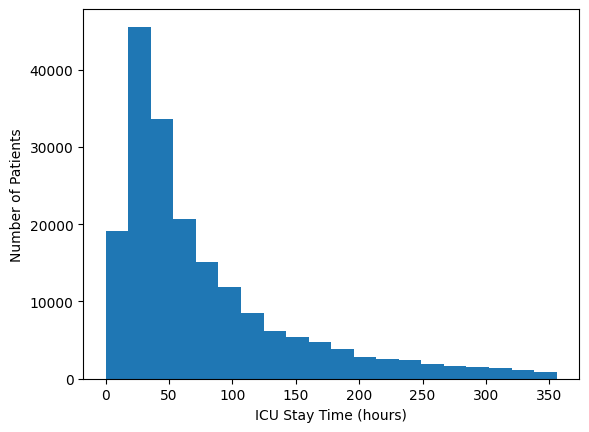

In [ ]:
query_stay_time = """
SELECT ABS(patient.unitdischargeoffset - patient.hospitaladmitoffset) as stay
FROM `physionet-data.eicu_crd.patient` as patient
"""

df = run_query(query_stay_time)
print(df['stay'].describe())

df['stay'] = df['stay'] / 60

# Visualize the distribution of ICU stay time using a histogram
plt.hist(df['stay'], range=(0, df['stay'].quantile(0.95)), bins=20)
plt.xlabel('ICU Stay Time (hours)')
plt.ylabel('Number of Patients')
plt.show()

# Fetch examples of good treatment



In [ ]:
# Patients who stayed in ICU shorter and Alive when discharging is treated as
# good pratice of diagnosis and treatment, but the stayd is at least over 100 mins.
query = """
SELECT patient.uniquepid,
       patient.patientunitstayid,
       apa.predictedicumortality,
       patient.unitdischargestatus,
       ABS(patient.unitdischargeoffset - patient.hospitaladmitoffset) as stay,
       patient.hospitaladmittime24,
       patient.hospitaldischargetime24,
       patient.hospitaladmitoffset,
       patient.unitdischargeoffset,
       patient.patienthealthsystemstayid,
       admitdx.admitdxname,
       patient.apacheadmissiondx,
       patient.hospitaldischargestatus,
       patient.unitdischargestatus
FROM `physionet-data.eicu_crd.admissiondx` as admitdx
JOIN `physionet-data.eicu_crd.patient` as patient
ON admitdx.patientunitstayid = patient.patientunitstayid
JOIN `physionet-data.eicu_crd.apachepatientresult` as apa
ON apa.patientunitstayid = patient.patientunitstayid
AND apa.actualicumortality IS NOT NULL
WHERE admitdx.admitdxname = 'Cardiovascular'
AND apa.predictedicumortality >= 0.5
AND patient.unitdischargestatus = 'Alive'
AND patient.hospitaldischargestatus = 'Alive'
AND ABS(patient.unitdischargeoffset - patient.hospitaladmitoffset) >= 2284
AND ABS(patient.unitdischargeoffset - patient.hospitaladmitoffset) <= 4284
ORDER BY patient.uniquepid
"""

query = """
SELECT DISTINCT(patient.patientunitstayid),
       patient.uniquepid,
FROM `physionet-data.eicu_crd.admissiondx` as admitdx
JOIN `physionet-data.eicu_crd.patient` as patient
ON admitdx.patientunitstayid = patient.patientunitstayid
JOIN `physionet-data.eicu_crd.apachepatientresult` as apa
ON apa.patientunitstayid = patient.patientunitstayid
AND apa.actualicumortality IS NOT NULL
WHERE admitdx.admitdxname = 'Cardiovascular'
AND apa.predictedicumortality >= 0.5
AND patient.unitdischargestatus = 'Alive'
AND patient.hospitaldischargestatus = 'Alive'
AND patient.unitdischargeoffset - patient.hospitaladmitoffset > 0
AND (
  SELECT COUNT(DISTINCT(diagnosisoffset))
  FROM `physionet-data.eicu_crd.diagnosis` as diag
  WHERE diag.patientunitstayid = patient.patientunitstayid
) >= 5
AND (
  SELECT COUNT(*)
  FROM `physionet-data.eicu_crd.medication` as medi
  WHERE medi.patientunitstayid = patient.patientunitstayid
) >= 5
AND (
  SELECT COUNT(*)
  FROM `physionet-data.eicu_crd.admissiondrug` as admitdrug
  WHERE admitdrug.patientunitstayid = patient.patientunitstayid
  AND drugdosage IS NOT NULL
) > 0
ORDER BY patient.patientunitstayid
"""
# 234 rows × 14 columns
df_good_examples = run_query(query)
# df_good_examples
df_good_examples.to_csv(path_prefix + 'good_example/good_practices.csv', index=False)

In [ ]:
# df_good_examples =

query = f"""
SELECT patient.gender,
       patient.age,
       patient.ethnicity,
       admitdx.admitdxname,
       patient.unitdischargeoffset,
       patient.hospitaladmitoffset,
       (patient.unitdischargeoffset - patient.hospitaladmitoffset) AS LOS
FROM `physionet-data.eicu_crd.patient` as patient
JOIN `physionet-data.eicu_crd.admissiondx` as admitdx
ON patient.patientunitstayid = admitdx.patientunitstayid
WHERE patient.patientunitstayid = 146619
AND patient.uniquepid = '002-76696'
AND admitdx.admitdxname = 'Cardiovascular'
LIMIT 1
"""

df = run_query(query)
df
# general_info = f"""
# (1) gender: {df.loc[0, "gender"]}
# (2) age: {df.loc[0, "age"]}
# (3) race: {df.loc[0, "ethnicity"]}
# (4) admission type: {df.loc[0, "admitdxname"]}
# (5) HOS admit time: {df.loc[0, "hospitaladmitoffset"]}
# (6) ICU discharge time: {df.loc[0, "unitdischargeoffset"]}
# (7) LOS of ICU: {df.loc[0, "LOS"]}
# """
# print(general_info)

,uniquepid,patientunitstayid,gender,age,ethnicity,admitdxname,unitdischargeoffset,hospitaladmitoffset,LOS
0,002-76696,146619,Male,74,Caucasian,Cardiovascular,7110,-7200,14310


In [ ]:
def fetch_gernal_info(pid, stay_id):
  query = f"""
  SELECT
        patient.gender,
        patient.age,
        patient.ethnicity,
        admitdx.admitdxname,
        patient.unitdischargeoffset,
        patient.hospitaladmitoffset,
        (patient.unitdischargeoffset - patient.hospitaladmitoffset) AS LOS
  FROM `physionet-data.eicu_crd.patient` as patient
  JOIN `physionet-data.eicu_crd.admissiondx` as admitdx
  ON patient.patientunitstayid = admitdx.patientunitstayid
  WHERE patient.patientunitstayid = {stay_id}
  AND patient.uniquepid = {pid}
  AND admitdx.admitdxname = 'Cardiovascular'
  LIMIT 1
  """
  df = run_query(query)
  df.to_string()

In [ ]:
"""
WHEN drugstartoffset < 148 THEN 'diag_0'
WHEN drugstartoffset >= 148 AND drugstartoffset < 564 THEN 'diag_1'
WHEN drugstartoffset >= 564 AND drugstartoffset < 4815 THEN 'diag_2'
WHEN drugstartoffset >= 4815 AND drugstartoffset < 4940 THEN 'diag_3'
WHEN drugstartoffset >= 4940 AND drugstartoffset < 6503 THEN 'diag_4'
ELSE 'diag_5'
"""

query = f"""
SELECT diagnosisoffset
FROM physionet-data.eicu_crd.diagnosis
WHERE patientunitstayid = 152661
ORDER BY diagnosisoffset
"""
df_patient_dx = run_query(query)
df_patient_dx


In [ ]:
# Query to get unique diagnosis offsets
query = """
SELECT diagnosisoffset
FROM physionet-data.eicu_crd.diagnosis
WHERE patientunitstayid = 146619
ORDER BY diagnosisoffset
"""

# Fetch unique diagnosis offsets
df_patient_dx = run_query(query)
unique_diag_offset = df_patient_dx['diagnosisoffset'].unique()

# Construct the CASE statement dynamically
case_statement = "CASE "
for i, offset in enumerate(unique_diag_offset):
    if i == 0:
        case_statement += f"WHEN drugstartoffset < {offset} THEN 'diag_{i}' "
    else:
        case_statement += f"WHEN drugstartoffset >= {unique_diag_offset[i-1]} AND drugstartoffset < {offset} THEN 'diag_{i}' "
case_statement += "ELSE 'diag_5' END AS time_range, "

# Construct the main query
main_query = f"""
SELECT
{case_statement}
drugname,
(drugstopoffset - drugstartoffset) AS duration,
drugstartoffset,
drugstopoffset,
dosage,
frequency,
gtc
FROM physionet-data.eicu_crd.medication
WHERE patientunitstayid = 146619
AND drugname IS NOT NULL
AND drugordercancelled = 'No'
ORDER BY time_range
"""

# Execute the main query
df = run_query(main_query)

time_ranges = df['time_range'].unique()

medications = ''

for time_range in sorted(time_ranges):
    medications += time_range + '\n'
    filtered_df = df[df['time_range'] == time_range]
    for _, row in filtered_df.iterrows():
        medications += "drugname:\n"
        medications += row['drugname'] + '\n'
        medications += "duration:\n"
        medications += str(row['duration']) + '\n'
        medications += "drugstartoffset:\n"
        medications += str(row['drugstartoffset']) + '\n'
        medications += "drugstopoffset:\n"
        medications += str(row['drugstopoffset']) + '\n'
        if row['dosage'] != '':
            medications += "dosage:\n"
            medications += str(row['dosage']) + '\n'
        medications += "frequency:\n"
        medications += str(row['frequency']) + '\n'
        medications += "gtc:\n"
        medications += str(row['gtc']) + '\n\n'

num_tokens_from_string(medications)

4090

In [ ]:
df_all_good_practices = pd.read_csv(path_prefix + 'good_example/good_practices.csv')
df_all_good_practices.loc[0]['patientunitstayid']
len(df_all_good_practices)

967

In [ ]:
for i in range(len(df_all_good_practices)):
  if i == 10:
    stay_id = df_all_good_practices.loc[i]['patientunitstayid']
    pid = df_all_good_practices.loc[i]['uniquepid']
    print(stay_id, pid)

158937 002-42148


In [ ]:
def gpt3_embedding(content, engine='text-embedding-ada-002'):
    content = content.encode(encoding='ASCII', errors="ignore").decode()
    response = openai.Embedding.create(input=content,engine=engine)
    vector = response['data'][0]['embedding']
    return vector

def save_json(filepath, payload):
    with open(filepath, 'w', encoding='utf-8') as outfile:
        json.dump(payload, outfile, ensure_ascii=False, sort_keys=True, indent=2)

General_info + Premedication

In [ ]:
stay_id_for_embed = 146619

def fetch_pre_medi(stay_id_for_embed):
  # Query to get unique diagnosis offsets
  query = f"""
  SELECT diagnosisoffset
  FROM physionet-data.eicu_crd.diagnosis
  WHERE patientunitstayid = {stay_id_for_embed}
  ORDER BY diagnosisoffset
  """

  # Fetch unique diagnosis offsets
  df_patient_dx = run_query(query)
  unique_diag_offset = df_patient_dx['diagnosisoffset'].unique()

  # Construct the CASE statement dynamically
  case_statement = "CASE "
  for i, offset in enumerate(unique_diag_offset):
      if i == 0:
          case_statement += f"WHEN drugstartoffset < {offset} THEN 'diag_{i}' "
      else:
          case_statement += f"WHEN drugstartoffset >= {unique_diag_offset[i-1]} AND drugstartoffset < {offset} THEN 'diag_{i}' "
  case_statement += f"ELSE 'diag_{i + 1}' END AS time_range, "

  # Construct the main query
  main_query = f"""
  SELECT *
  FROM
  (
    SELECT
    {case_statement}
    drugname,
    (drugstopoffset - drugstartoffset) AS duration,
    drugstartoffset,
    drugstopoffset,
    dosage,
    frequency,
    gtc
    FROM physionet-data.eicu_crd.medication
    WHERE patientunitstayid = {stay_id_for_embed}
    AND drugname IS NOT NULL
    AND drugordercancelled = 'No'
    ORDER BY time_range
  ) subquery
  WHERE time_range = 'diag_0'
  ORDER BY time_range
  """

  df_embed = run_query(main_query)
  patient_condition = df_embed.to_string()

In [ ]:
query = f"""
SELECT *
FROM `physionet-data.eicu_crd.diagnosis`
WHERE patientunitstayid = 146619
ORDER BY diagnosisoffset
"""
diagnose_count = 1
df_patient_dx = run_query(query)
df_patient_dx
grouped = df_patient_dx.groupby('diagnosisoffset')

final_diagnoses = ''

for name, group in grouped:
  final_diagnoses += f'diagnos_{diagnose_count}, offset: {name}\n'
  diagnoses = group['diagnosisstring'].tolist()  # get diagnoses for this group
  diagnose_count += 1
  for i, diagnosis in enumerate(diagnoses, start=1):
      final_diagnoses += f'{i}. {diagnosis}\n'
  final_diagnoses += '\n'

print(final_diagnoses)

# for name, group in grouped:
#     print(f'diagnos_{diagnose_count}, offset: {name}')
#     diagnoses = group['diagnosisstring'].tolist()  # get diagnoses for this group
#     diagnose_count += 1
#     for i, diagnosis in enumerate(diagnoses, start=1):
#         print(f'{i}. {diagnosis}')
#     print()  # print an empty line between groups

diagnos_1, offset: 148
1. pulmonary|respiratory failure|acute respiratory failure
2. cardiovascular|chest pain / ASHD|coronary artery disease
3. cardiovascular|cardiac arrest|cardiac arrest|initial rhythm: ventricular tachycardia
4. cardiovascular|chest pain / ASHD|acute coronary syndrome
5. cardiovascular|cardiac arrest|cardiac arrest|witnessed, < 15 minutes CPR

diagnos_2, offset: 564
1. pulmonary|respiratory failure|acute respiratory failure
2. cardiovascular|chest pain / ASHD|acute coronary syndrome
3. cardiovascular|chest pain / ASHD|coronary artery disease
4. cardiovascular|cardiac arrest|cardiac arrest|initial rhythm: ventricular tachycardia
5. cardiovascular|cardiac arrest|cardiac arrest|witnessed, < 15 minutes CPR

diagnos_3, offset: 4815
1. pulmonary|respiratory failure|acute respiratory failure
2. cardiovascular|chest pain / ASHD|acute coronary syndrome|acute myocardial infarction (with ST elevation)
3. renal|disorder of kidney|acute renal failure
4. endocrine|glucose metabo

In [ ]:
# Split the strings into lists
medication_list = medications.split('diag_')[1:]
diagnosis_list = final_diagnoses.split('diagnos_')[1:]

# Merge the two lists
merged_list = []
for i in range(len(medication_list)):
    merged_list.append('medication_' + medication_list[i])
    if i < len(diagnosis_list):
        merged_list.append('diagnos_' + diagnosis_list[i])

# Join the merged list into a single string
merged_string = '\n'.join(merged_list)

num_tokens_from_string(merged_string)

4937

In [ ]:
query = f"""
SELECT
  CASE
    WHEN drugstartoffset < 148 THEN 'diag_0'
    WHEN drugstartoffset >= 148 AND drugstartoffset < 564 THEN 'diag_1'
    WHEN drugstartoffset >= 564 AND drugstartoffset < 4815 THEN 'diag_2'
    WHEN drugstartoffset >= 4815 AND drugstartoffset < 4940 THEN 'diag_3'
    WHEN drugstartoffset >= 4940 AND drugstartoffset < 6503 THEN 'diag_4'
    ELSE 'diag_5'
  END AS time_range,
  drugname,
  (drugstopoffset - drugstartoffset) AS duration,
  drugstartoffset,
  drugstopoffset,
  dosage,
  frequency,
  gtc
FROM `physionet-data.eicu_crd.medication`
WHERE patientunitstayid = 146619
AND drugname IS NOT NULL
AND drugordercancelled = 'No'
ORDER BY time_range
"""

df = run_query(query)
df_patient_medi.to_csv(path_prefix + 'medi_del.csv', index=False)
for i in df_patient_medi['drugorderoffset']:
  print(i)

time_ranges = df['time_range'].unique()

total_string = ''

for time_range in sorted(time_ranges):
    total_string += time_range + '\n'
    filtered_df = df[df['time_range'] == time_range]
    for _, row in filtered_df.iterrows():
        total_string += "drugname:\n"
        total_string += row['drugname'] + '\n'
        total_string += "duration:\n"
        total_string += str(row['duration']) + '\n'
        total_string += "drugstartoffset:\n"
        total_string += str(row['drugstartoffset']) + '\n'
        total_string += "drugstopoffset:\n"
        total_string += str(row['drugstopoffset']) + '\n'
        if row['dosage'] is not None:
            total_string += "dosage:\n"
            total_string += str(row['dosage']) + '\n'
        total_string += "frequency:\n"
        total_string += str(row['frequency']) + '\n'
        total_string += "gtc:\n"
        total_string += str(row['gtc']) + '\n\n'

print(total_string)

## Fetch examples of bad treatment

In [ ]:
# Patients who stayed in ICU longer and died eventually (Expired) is treated
# as bad pratice of diagnosis and treatment, but the stayd is at least over
# 100 mins.
query = """
SELECT patient.uniquepid,
       patient.patientunitstayid,
       apa.predictedicumortality,
       patient.unitdischargestatus,
       ABS(patient.unitdischargeoffset - patient.hospitaladmitoffset) as stay,
       patient.hospitaladmittime24,
       patient.hospitaldischargetime24,
       patient.hospitaladmitoffset,
       patient.unitdischargeoffset,
       patient.patienthealthsystemstayid,
       admitdx.admitdxname,
       patient.apacheadmissiondx,
       patient.hospitaldischargestatus,
       patient.unitdischargestatus
FROM `physionet-data.eicu_crd.admissiondx` as admitdx
JOIN `physionet-data.eicu_crd.patient` as patient
ON admitdx.patientunitstayid = patient.patientunitstayid
JOIN `physionet-data.eicu_crd.apachepatientresult` as apa
ON apa.patientunitstayid = patient.patientunitstayid
AND apa.actualicumortality IS NOT NULL
WHERE admitdx.admitdxname = 'Cardiovascular'
AND apa.predictedicumortality <= 0.5
AND patient.unitdischargestatus = 'Expired'
AND ABS(patient.unitdischargeoffset - patient.hospitaladmitoffset) >= 2284
AND ABS(patient.unitdischargeoffset - patient.hospitaladmitoffset) <= 4284
ORDER BY ABS(patient.unitdischargeoffset - patient.hospitaladmitoffset)
LIMIT 100
"""

df_bad_examples = run_query(query)
df_bad_examples

,uniquepid,patientunitstayid,predictedicumortality,unitdischargestatus,stay,hospitaladmittime24,hospitaldischargetime24,hospitaladmitoffset,unitdischargeoffset,patienthealthsystemstayid,admitdxname,apacheadmissiondx,hospitaldischargestatus,unitdischargestatus_1
0,030-62774,3083718,0.363253,Expired,2293,04:13:00,20:51:00,-873,1420,2503853,Cardiovascular,"Sepsis, renal/UTI (including bladder)",Expired,Expired
1,030-62774,3083718,0.420588,Expired,2293,04:13:00,20:51:00,-873,1420,2503853,Cardiovascular,"Sepsis, renal/UTI (including bladder)",Expired,Expired
2,027-19134,2734444,0.113856,Expired,2296,08:17:00,01:30:00,-1,2295,2199717,Cardiovascular,"Sepsis, renal/UTI (including bladder)",Expired,Expired
3,027-19134,2734444,0.095877,Expired,2296,08:17:00,01:30:00,-1,2295,2199717,Cardiovascular,"Sepsis, renal/UTI (including bladder)",Expired,Expired
4,027-89321,2885702,0.104145,Expired,2301,04:00:00,18:21:00,-121,2180,2339762,Cardiovascular,"Sepsis, pulmonary",Expired,Expired
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,027-209700,2728306,0.198572,Expired,2437,21:28:08,14:05:00,-1696,741,2193993,Cardiovascular,"Sepsis, pulmonary",Expired,Expired
96,027-209700,2728306,0.201449,Expired,2437,21:28:08,14:05:00,-1696,741,2193993,Cardiovascular,"Sepsis, pulmonary",Expired,Expired
97,027-154120,2792277,0.056737,Expired,2439,06:36:00,23:15:00,-665,1774,2253276,Cardiovascular,"Sepsis, cutaneous/soft tissue",Expired,Expired
98,027-154120,2792277,0.060671,Expired,2439,06:36:00,23:15:00,-665,1774,2253276,Cardiovascular,"Sepsis, cutaneous/soft tissue",Expired,Expired


# Good Practice

In [ ]:
good_practice_stay_id = 2282742

In [ ]:
query = f"""
SELECT *
FROM `physionet-data.eicu_crd.diagnosis`
WHERE patientunitstayid = {good_practice_stay_id}
ORDER BY diagnosisid
"""

df_patient_dx = run_query(query)
df_patient_dx

,diagnosisid,patientunitstayid,activeupondischarge,diagnosisoffset,diagnosisstring,icd9code,diagnosispriority
0,28344842,2282742,True,23,cardiovascular|chest pain / ASHD|acute coronar...,"410.41, I21.19",Primary


In [ ]:
query = f"""
SELECT *
FROM `physionet-data.eicu_crd.treatment`
WHERE patientunitstayid = {good_practice_stay_id}
ORDER BY treatmentid
"""

df_patient_tre = run_query(query)
df_patient_tre

,treatmentid,patientunitstayid,treatmentoffset,treatmentstring,activeupondischarge
0,56336040,2282742,23,cardiovascular|non-operative procedures|cardia...,True
1,56447864,2282742,23,cardiovascular|non-operative procedures|cardia...,True
2,56716064,2282742,23,cardiovascular|consultations|Cardiology consul...,True


In [ ]:
query = f"""
SELECT *
FROM `physionet-data.eicu_crd.medication`
WHERE patientunitstayid = {good_practice_stay_id}
AND drugname IS NOT NULL
ORDER BY medicationid
"""

df_patient_medi = run_query(query)
df_patient_medi

In [ ]:
infusion_drug_query = f"""
SELECT *
FROM `physionet-data.eicu_crd.infusiondrug`
WHERE patientunitstayid = {good_practice_stay_id}
"""

df_infusion = run_query(infusion_drug_query)
df_infusion

,infusiondrugid,patientunitstayid,infusionoffset,drugname,drugrate,infusionrate,drugamount,volumeoffluid,patientweight
0,47959429,2282742,4,Nitroglycerin (ml/hr),10.9,NaN,NaN,NaN,NaN


In [ ]:
allergy_query = f"""
SELECT *
FROM `physionet-data.eicu_crd.allergy`
WHERE patientunitstayid = {good_practice_stay_id}
"""
df_allergy = run_query(allergy_query)
df_allergy

,allergyid,patientunitstayid,allergyoffset,allergyenteredoffset,allergynotetype,specialtytype,usertype,rxincluded,writtenineicu,drugname,allergytype,allergyname,drughiclseqno
0,2310149,2282742,18,23,Admission,eCM Primary,THC Nurse,True,True,XARELTO ...,Drug,XARELTO ...,35915


In [ ]:
apache_aps_var = f"""
SELECT *
FROM `physionet-data.eicu_crd.apacheapsvar`
WHERE patientunitstayid = {good_practice_stay_id}
"""
df_apache_aps_var = run_query(apache_aps_var)
df_apache_aps_var

,apacheapsvarid,patientunitstayid,intubated,vent,dialysis,eyes,motor,verbal,meds,urine,...,ph,hematocrit,creatinine,albumin,pao2,pco2,bun,glucose,bilirubin,fio2
0,763415,2282742,0,0,0,4,6,5,0,886.896,...,-1.0,32.3,1.16,-1.0,-1.0,-1.0,35.0,161.0,-1.0,-1.0


In [ ]:
apache_patient_result = f"""
SELECT predictedicumortality,
       actualicumortality,
       predictedhospitalmortality,
       actualhospitalmortality,
       apachescore,
       apacheversion
FROM `physionet-data.eicu_crd.apachepatientresult`
WHERE patientunitstayid = {good_practice_stay_id}
"""

df_apache_res = run_query(apache_patient_result)
df_apache_res

,predictedicumortality,actualicumortality,predictedhospitalmortality,actualhospitalmortality,apachescore,apacheversion
0,0.037582,ALIVE,0.073922,ALIVE,52,IV
1,0.029397,ALIVE,0.049250,ALIVE,52,IVa


In [ ]:
apache_patient_pred = f"""
SELECT *
FROM `physionet-data.eicu_crd.apachepredvar`
WHERE patientunitstayid = {good_practice_stay_id}
"""

df_apache_pred = run_query(apache_patient_pred)
df_apache_pred

,apachepredvarid,patientunitstayid,sicuday,saps3day1,saps3today,saps3yesterday,gender,teachtype,region,bedcount,...,creatinine,dischargelocation,visitnumber,amilocation,day1meds,day1verbal,day1motor,day1eyes,day1pao2,day1fio2
0,1643940,2282742,1,0,0,0,1,0,3,22,...,1.16,7,1,4,0,5,6,4,-1.0,-1.0


# Bad Practice

In [ ]:
bad_practice_stay_id = 593543

In [ ]:
query = f"""
SELECT uniquepid,
       patientunitstayid,
       gender,
       age,
       ethnicity
FROM `physionet-data.eicu_crd.patient`
WHERE patientunitstayid = {bad_practice_stay_id}
"""

df_general_info = run_query(query)
df_general_info

,uniquepid,patientunitstayid,gender,age,ethnicity
0,006-96859,593543,Female,76,Caucasian


In [ ]:
query = f"""
SELECT *
FROM `physionet-data.eicu_crd.diagnosis`
WHERE patientunitstayid = {bad_practice_stay_id}
ORDER BY diagnosisid
"""

df_patient_dx = run_query(query)
df_patient_dx
# dx_pairs = zip(df_patient_dx['icd9code'], df_patient_dx['diagnosisstring'])
# for icd9, dx in dx_pairs:
#   print(f"{icd9}: {dx}")

,diagnosisid,patientunitstayid,activeupondischarge,diagnosisoffset,diagnosisstring,icd9code,diagnosispriority
0,11178666,593543,False,25,pulmonary|respiratory failure|acute respirator...,"518.81, J96.00",Other
1,11318448,593543,True,500,pulmonary|respiratory failure|acute respirator...,"518.81, J96.00",Other
2,11440084,593543,True,500,cardiovascular|shock / hypotension|sepsis|seps...,"995.92, R65.20",Primary
3,11526845,593543,False,25,cardiovascular|shock / hypotension|sepsis|seps...,"995.92, R65.20",Primary
4,11913443,593543,True,500,cardiovascular|shock / hypotension|sepsis|severe,"995.92, R65.2",Primary
5,12106054,593543,False,25,cardiovascular|shock / hypotension|sepsis|severe,"995.92, R65.2",Primary


In [ ]:
query = f"""
SELECT *
FROM `physionet-data.eicu_crd.treatment`
WHERE patientunitstayid = {bad_practice_stay_id}
ORDER BY treatmentid
"""

df_patient_tre = run_query(query)
df_patient_tre

,treatmentid,patientunitstayid,treatmentoffset,treatmentstring,activeupondischarge
0,23885366,593543,25,pulmonary|ventilation and oxygenation|mechanic...,False
1,25501489,593543,25,renal|intravenous fluid|normal saline administ...,False
2,26118544,593543,25,cardiovascular|shock|vasopressors|norepinephri...,False
3,26465576,593543,25,renal|intravenous fluid|normal saline administ...,False


In [ ]:
query = f"""
SELECT *
FROM `physionet-data.eicu_crd.medication`
WHERE patientunitstayid = {bad_practice_stay_id}
AND drugname IS NOT NULL
ORDER BY medicationid
"""

df_patient_medi = run_query(query)
df_patient_medi

,medicationid,patientunitstayid,drugorderoffset,drugstartoffset,drugivadmixture,drugordercancelled,drugname,drughiclseqno,dosage,routeadmin,frequency,loadingdose,prn,drugstopoffset,gtc
0,24061317,593543,2,-1042,No,Yes,MAGNESIUM OXIDE 400 MG TAB,609,400 mg,PO,Q4H (int) X2,,No,-802,59
1,24932575,593543,2,-622,No,No,hydroCORTisone (PF) 100 MG INJ,2866,25 mg,IV,Q8H,,No,718,68
2,25525442,593543,2,-1512,No,No,INSULIN-LISPRO (rDNA) *UNIT* INJ,11528,,SubQ,QHS,,Yes,718,71
3,25863743,593543,2,-1512,No,No,GLUCAGON 1 MG (1 UNIT) INJ,19078,1 mg,SubQ,ONCALL,,Yes,718,59
4,25910455,593543,2,-1009,No,No,NORCO 5/325 TAB,1730,2 Tab,PO,Q4H,,Yes,718,2
5,26230093,593543,2,-1512,No,No,INSULIN-LISPRO (rDNA) *UNIT* INJ,11528,,SubQ,TIDAC,,Yes,718,71
6,26702252,593543,2,-1512,No,No,INSULIN-LISPRO (rDNA) *UNIT* INJ,11528,,SubQ,Q4H (int),,Yes,718,71
7,27234013,593543,2,-1512,No,No,DEXTROSE 50% 25 GRAM/50 ML SYR,926,25 Gm,IV Push,ONCALL,,Yes,718,59
8,27256423,593543,2,-1514,No,No,acetaMINOPHEN 325 MG TAB,1866,650 mg,PO,Q4H,,Yes,718,2
9,27861720,593543,446,435,No,No,LORazepam 2 MG/1 ML 1 ML SYR,4846,0.5 mg,IV Push,Q1H,,Yes,718,83


In [ ]:
# drugorderoffset < diagnosisoffset means medication before diagnosis
pre_medi_query = f"""
SELECT DISTINCT(medi.medicationid),
       medi.patientunitstayid,
       medi.drugorderoffset,
       medi.drugstartoffset,
       medi.drugivadmixture,
       medi.drugordercancelled,
       medi.drugname,
       medi.drughiclseqno,
       medi.dosage,
       medi.routeadmin,
       medi.frequency,
       medi.loadingdose,
       medi.prn,
       medi.drugstopoffset,
       medi.gtc
FROM `physionet-data.eicu_crd.medication` as medi
JOIN `physionet-data.eicu_crd.diagnosis` as diag
ON diag.patientunitstayid = medi.patientunitstayid
WHERE medi.patientunitstayid = {bad_practice_stay_id}
AND medi.drugname IS NOT NULL
AND medi.drugorderoffset < diag.diagnosisoffset
ORDER BY medicationid
"""
df_pre_medi = run_query(pre_medi_query)
df_pre_medi

,medicationid,patientunitstayid,drugorderoffset,drugstartoffset,drugivadmixture,drugordercancelled,drugname,drughiclseqno,dosage,routeadmin,frequency,loadingdose,prn,drugstopoffset,gtc
0,23077827,955182,1379,1333,No,No,GLUCAGON 1 MG (1 UNIT) INJ,19078,1 mg,SubQ,ONCALL,,Yes,2267,59
1,23138534,955182,581,577,No,No,VASOPRESSIN 60 UNITS in 100 mL NS,2839,60 unit(s),IVPB,,,No,2267,68
2,23334879,955182,1379,1333,No,No,GLUCOSE 15 GRAM/60 ML BQ LIQ,807,30 Gm,PO,ONCALL,,Yes,2267,59
3,23353829,955182,2,384,No,No,FAMOTIDINE 20 MG/2 ML SDV INJ,35085,20 mg,IV Push,DAILY,,No,2267,65
4,23778931,955182,852,849,No,No,DEXTROSE 50% 25 GRAM/50 ML SYR,926,25 Gm,IV Push,1XONLY,,No,957,59
5,24156559,955182,1379,1333,No,No,DEXTROSE 50% 25 GRAM/50 ML SYR,926,25 Gm,IV Push,ONCALL,,Yes,2267,59
6,24586692,955182,1379,1333,No,No,GLUCOSE 15 GRAM/60 ML BQ LIQ,807,15 Gm,PO,ONCALL,,Yes,2267,59
7,25180219,955182,2,-190,No,No,LACTATED RINGERS 1000 ML LVP,525,"1,000 mL",IV,1XONLY,,No,51,59
8,25592906,955182,2,-51,No,No,MORPHINE 2 MG/1 ML 1 ML SYR,1694,2 mg,IV Push,Q2H,,Yes,2267,2
9,25853876,955182,945,930,Yes,No,SODIUM BICARBONATE 8.4% 50 ML INJ,523,3 mL,IV,,,No,2267,59


In [ ]:
# drugorderoffset > diagnosisoffset means medication after diagnosis
post_medi_query = f"""
SELECT medi.medicationid,
       medi.patientunitstayid,
       medi.drugorderoffset,
       medi.drugstartoffset,
       medi.drugivadmixture,
       medi.drugordercancelled,
       medi.drugname,
       medi.drughiclseqno,
       medi.dosage,
       medi.routeadmin,
       medi.frequency,
       medi.loadingdose,
       medi.prn,
       medi.drugstopoffset,
       medi.gtc
FROM `physionet-data.eicu_crd.medication` as medi
JOIN `physionet-data.eicu_crd.diagnosis` as diag
ON diag.patientunitstayid = medi.patientunitstayid
WHERE medi.patientunitstayid = {bad_practice_stay_id}
AND medi.drugname IS NOT NULL
AND medi.drugorderoffset >= diag.diagnosisoffset
ORDER BY medicationid
"""
df_post_medi = run_query(post_medi_query)
df_post_medi

,medicationid,patientunitstayid,drugorderoffset,drugstartoffset,drugivadmixture,drugordercancelled,drugname,drughiclseqno,dosage,routeadmin,frequency,loadingdose,prn,drugstopoffset,gtc
0,19914997,520130,31,30,No,Yes,MORPHINE,1694,MG,IV,ONDEM,,Yes,291,2
1,19914997,520130,31,30,No,Yes,MORPHINE,1694,MG,IV,ONDEM,,Yes,291,2
2,19914997,520130,31,30,No,Yes,MORPHINE,1694,MG,IV,ONDEM,,Yes,291,2
3,19914997,520130,31,30,No,Yes,MORPHINE,1694,MG,IV,ONDEM,,Yes,291,2
4,19914997,520130,31,30,No,Yes,MORPHINE,1694,MG,IV,ONDEM,,Yes,291,2
5,19914997,520130,31,30,No,Yes,MORPHINE,1694,MG,IV,ONDEM,,Yes,291,2
6,21849675,520130,32,31,No,No,MORPHINE,1694,MG,IV,ONDEM,,No,291,2
7,21849675,520130,32,31,No,No,MORPHINE,1694,MG,IV,ONDEM,,No,291,2
8,21849675,520130,32,31,No,No,MORPHINE,1694,MG,IV,ONDEM,,No,291,2
9,21849675,520130,32,31,No,No,MORPHINE,1694,MG,IV,ONDEM,,No,291,2


In [ ]:
infusion_drug_query = f"""
SELECT *
FROM `physionet-data.eicu_crd.infusiondrug`
WHERE patientunitstayid = {bad_practice_stay_id}
"""

df_infusion = run_query(infusion_drug_query)
df_infusion

,infusiondrugid,patientunitstayid,infusionoffset,drugname,drugrate,infusionrate,drugamount,volumeoffluid,patientweight


In [ ]:
allergy_query = f"""
SELECT *
FROM `physionet-data.eicu_crd.allergy`
WHERE patientunitstayid = {bad_practice_stay_id}
"""
df_allergy = run_query(allergy_query)
df_allergy

,allergyid,patientunitstayid,allergyoffset,allergyenteredoffset,allergynotetype,specialtytype,usertype,rxincluded,writtenineicu,drugname,allergytype,allergyname,drughiclseqno
0,763893,593543,19,25,Admission,eCM Primary,THC Nurse,True,True,,Non Drug,SEE CERNER ...,<NA>


In [ ]:
apache_aps_var = f"""
SELECT *
FROM `physionet-data.eicu_crd.apacheapsvar`
WHERE patientunitstayid = {bad_practice_stay_id}
"""
df_apache_aps_var = run_query(apache_aps_var)
df_apache_aps_var

,apacheapsvarid,patientunitstayid,intubated,vent,dialysis,eyes,motor,verbal,meds,urine,...,ph,hematocrit,creatinine,albumin,pao2,pco2,bun,glucose,bilirubin,fio2
0,306008,520130,0,1,0,-1,-1,-1,1,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [ ]:
apache_patient_result = f"""
SELECT predictedicumortality,
       actualicumortality,
       predictedhospitalmortality,
       actualhospitalmortality,
       apachescore,
       apacheversion
FROM `physionet-data.eicu_crd.apachepatientresult`
WHERE patientunitstayid = 593543
"""

df_apache_res = run_query(apache_patient_result)
df_apache_res

,predictedicumortality,actualicumortality,predictedhospitalmortality,actualhospitalmortality,apachescore,apacheversion
0,0.225678,EXPIRED,0.440713,EXPIRED,104,IV
1,0.253559,EXPIRED,0.419920,EXPIRED,104,IVa


In [ ]:
apache_patient_pred = f"""
SELECT *
FROM `physionet-data.eicu_crd.apachepredvar`
WHERE patientunitstayid = {bad_practice_stay_id}
"""

df_apache_pred = run_query(apache_patient_pred)
df_apache_pred

,apachepredvarid,patientunitstayid,sicuday,saps3day1,saps3today,saps3yesterday,gender,teachtype,region,bedcount,...,creatinine,dischargelocation,visitnumber,amilocation,day1meds,day1verbal,day1motor,day1eyes,day1pao2,day1fio2
0,1449873,593543,1,0,0,0,1,0,3,16,...,4.1,9,1,-1,0,1,5,4,-1.0,-1.0
